In [1]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py39hd257fcd_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.9/dist-packages/ lib/python3.9/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4243    0  4243    0     0  25255      0 --:--:-- --:--:-- --:--:-- 25255
100  517k  100  517k    0     0   979k      0 --:--:-- --:--:-- --:--:--  979k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4215    0  4215    0     0  18406      0 --:--:-- --:--:-- --:--:-- 18326
100  389k  100  389k    0     0   674k      0 --:--:-- --:--:-- --:--:--  674k


In [2]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from transformers import BertModel, BertTokenizer
import pandas as pd
import numpy as np
import talib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [4]:

# 1. Split the data into training and validation sets
def split_data(df, train_ratio=0.8):
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx].reset_index(drop=True)
    val_df = df.iloc[split_idx:].reset_index(drop=True)
    return train_df, val_df


In [5]:

# 2. Modify the Dataset class to handle sentiment categories
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_text_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_text_length = max_text_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row["Article Text"]
        ohlcv_data = row[["Stock Open", "Stock High", "Stock Low", "Stock Close", "volume", "SMA", "RSI", "ADX", "EMA", "ATR", "MACD"]].values.astype(np.float32)
        sentiment_label = row["overall_sentiment_label"]

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_text_length,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )

        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        sentiment_mapping = {
            "Bearish": 0,
            "Somewhat-Bearish": 1,
            "Neutral": 2,
            "Somewhat-Bullish": 3,
            "Bullish": 4,
        }

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "ohlcv_data": torch.tensor(ohlcv_data),
            "sentiment_label": torch.tensor(sentiment_mapping[sentiment_label], dtype=torch.long),
        }


In [6]:

# 3. Modify the model architecture to predict sentiment categories
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name, num_lstm_layers=1, hidden_size=128, dropout_rate=0.2):
        super(MultimodalModel, self).__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.lstm = nn.LSTM(input_size=11, hidden_size=hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + self.bert.config.hidden_size, 5)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask, ohlcv_data):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = bert_output.pooler_output

        ohlcv_data = ohlcv_data.unsqueeze(1)
        lstm_output, _ = self.lstm(ohlcv_data)
        lstm_output = lstm_output[:, -1, :]

        combined = torch.cat([text_embedding, lstm_output],    dim=1)
        combined = self.dropout(combined)
        output = self.fc(combined)
        return output



In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    allpreds,alllabels=[],[]
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ohlcv_data = batch["ohlcv_data"].to(device)
        sentiment_labels = batch["sentiment_label"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask, ohlcv_data)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, sentiment_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct_predictions += torch.sum(preds == sentiment_labels)
        allpreds+=preds.tolist()
        alllabels+=sentiment_labels.tolist()

    print(classification_report(allpreds, alllabels))
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss / len(dataloader), accuracy, classification_report(allpreds, alllabels, output_dict=True)


In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    correct_predictions = 0
    allpreds,alllabels=[],[]
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            ohlcv_data = batch["ohlcv_data"].to(device)
            sentiment_labels = batch["sentiment_label"].to(device)

            outputs = model(input_ids, attention_mask, ohlcv_data)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, sentiment_labels)

            epoch_loss += loss.item()
            correct_predictions += torch.sum(preds == sentiment_labels)
            allpreds+=preds.tolist()
            alllabels+=sentiment_labels.tolist()

    print(classification_report(allpreds, alllabels))
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss / len(dataloader), accuracy, classification_report(allpreds, alllabels, output_dict=True)


In [9]:
def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs):
    alltrainreports, allvalreports = [],[]
    for epoch in range(num_epochs):
        train_loss, train_acc, train_report = train_epoch(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_acc, val_report = evaluate(model, val_dataloader, criterion, device)
        alltrainreports.append(train_report)
        allvalreports.append(val_report)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")
    return alltrainreports, allvalreports


In [10]:
# 2. Preprocess the data using TA-Lib
def preprocess_data(df):
    df['SMA'] = talib.SMA(
            df['Stock Close'], timeperiod=14)
    df['EMA'] = talib.EMA(
        df['Stock Close'], timeperiod=14)
    df['RSI'] = talib.RSI(
        df['Stock Close'], timeperiod=14)
    df['MACD'], _, _ = talib.MACD(
        df['Stock Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['ATR'] = talib.ATR(
        df['Stock High'], df['Stock Low'], df['Stock Close'], timeperiod=14)
    df["ADX"] = talib.ADX(
        df["Stock High"].values, 
        df["Stock Low"].values, 
        df["Stock Close"].values
        )
    df.dropna(inplace=True)
    print('data has been preprocessed')
    return df

In [19]:
# Load and preprocess data
# df = pd.read_csv("data/stock_news_data_AAPL.csv")
# df = preprocess_data(df)
# train_df, val_df = split_data(df)

train_df, val_df = pd.read_csv("data/train.csv"),pd.read_csv("data/test.csv")

train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)
val_all_df = preprocess_data(pd.read_csv("data/stock_news_data_TSLA.csv"))

data has been preprocessed
data has been preprocessed
data has been preprocessed


In [20]:
train_df.head()

,Article Headline,Article URL,Article Text,overall_sentiment_score,overall_sentiment_label,Stock Open,Stock Close,Stock High,Stock Low,volume,num_trades,adj_close,Ticker,SMA,EMA,RSI,MACD,ATR,ADX
33,EXCLUSIVE from Bitcoin 2022: TradeZing CEO Jor...,https://www.benzinga.com/markets/cryptocurrenc...,"Detroit-based Benzinga, a media and data provi...",-0.055666,Neutral,163.92,165.07,166.5984,163.57,68843424.0,574580.0,164.928106,AAPL,171.944286,169.303077,44.101673,2.103217,4.231021,11.647272
34,"China Lockdowns, Factory Closures Seen Hurting...",https://www.investors.com/news/technology/appl...,"Apple Stock: China Lockdowns, Factory Closures...",-0.051895,Neutral,165.02,167.40,167.8200,163.91,67566065.0,546660.0,166.548430,AAPL,171.118571,169.049334,47.632444,1.789685,4.208091,11.689272
35,EXCLUSIVE From Bitcoin 2022: How To Increase L...,https://www.benzinga.com/markets/cryptocurrenc...,"Detroit-based Benzinga, a media and data provi...",-0.053154,Neutral,168.76,167.23,168.8800,166.10,67515353.0,590666.0,167.349497,AAPL,170.365714,168.806756,47.397210,1.510084,4.106084,11.392987
36,Garmin ( GRMN ) Strengthens Fitness Segment ...,https://www.zacks.com/stock/news/1904502/garmi...,Garmin (GRMN) expands fitness offerings with t...,0.151760,Somewhat-Bullish,168.91,166.42,171.5300,165.91,86895494.0,748146.0,168.808299,AAPL,169.780714,168.488522,46.225814,1.209199,4.214221,10.817941
37,"SNAP Q1 Earnings Miss Estimates, User Growth A...",https://www.zacks.com/stock/news/1905492/snap-...,Snap's (SNAP) first-quarter results reflect be...,-0.051587,Neutral,166.46,161.79,167.8699,161.50,84550744.0,725782.0,164.231066,AAPL,168.886429,167.595386,40.121843,0.590338,4.368198,10.939776


In [21]:
# distilbert-base-uncased
# bert-base-uncased
# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
train_dataset = MultimodalDataset(train_df, tokenizer, max_text_length=128)
val_dataset = MultimodalDataset(val_df, tokenizer, max_text_length=128)
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=1, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalModel("ProsusAI/finbert").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train and evaluate the model
num_epochs = 10


Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
alltrainreps,allvalreps = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

              precision    recall  f1-score   support

           0       0.08      0.11      0.09         9
           1       0.04      0.18      0.07        17
           2       0.66      0.48      0.55       927
           3       0.28      0.33      0.30       399
           4       0.00      0.00      0.00        17

    accuracy                           0.42      1369
   macro avg       0.21      0.22      0.20      1369
weighted avg       0.53      0.42      0.46      1369



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.33      0.68      0.44       282
           3       0.87      0.38      0.53       785
           4       0.00      0.00      0.00         0

    accuracy                           0.46      1067
   macro avg       0.24      0.21      0.20      1067
weighted avg       0.73      0.46      0.51      1067

Epoch 1/10, Train Loss: 1.2462865959766298, Train Acc: 0.4200146092037984, Val Loss: 1.1932326976450784, Val Acc: 0.4620431115276476


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.74      0.53      0.62       934
           3       0.37      0.40      0.39       433
           4       0.00      0.00      0.00         1

    accuracy                           0.49      1369
   macro avg       0.22      0.19      0.20      1369
weighted avg       0.62      0.49      0.55      1369



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.63      0.67      0.65       546
           3       0.70      0.46      0.56       521
           4       0.00      0.00      0.00         0

    accuracy                           0.57      1067
   macro avg       0.26      0.23      0.24      1067
weighted avg       0.66      0.57      0.60      1067

Epoch 2/10, Train Loss: 1.147096686585005, Train Acc: 0.49013878743608474, Val Loss: 1.0974863082757036, Val Acc: 0.569821930646673


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.74      0.66      0.70       748
           3       0.66      0.50      0.57       603
           4       0.05      0.39      0.08        18

    accuracy                           0.59      1369
   macro avg       0.29      0.31      0.27      1369
weighted avg       0.69      0.59      0.63      1369



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.73      0.65      0.69       659
           3       0.54      0.52      0.53       355
           4       0.38      0.26      0.31        53

    accuracy                           0.59      1067
   macro avg       0.33      0.29      0.31      1067
weighted avg       0.65      0.59      0.62      1067

Epoch 3/10, Train Loss: 1.0045063079789627, Train Acc: 0.5887509130752374, Val Loss: 1.107664696083185, Val Acc: 0.5885660731021556
              precision    recall  f1-score   support

           0       0.08      1.00      0.14         1
           1       0.12      0.75      0.21        12
           2       0.83      0.79      0.81       706
           3       0.79      0.68      0.73       538
           4       0.52      0.69      0.59       112

    accuracy                           0.74      1369

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.12      0.45      0.20        22
           2       0.64      0.68      0.66       545
           3       0.65      0.50      0.56       454
           4       0.32      0.26      0.29        46

    accuracy                           0.58      1067
   macro avg       0.35      0.38      0.34      1067
weighted avg       0.62      0.58      0.59      1067

Epoch 4/10, Train Loss: 0.7344303872696188, Train Acc: 0.7384952520087655, Val Loss: 1.1337338381018331, Val Acc: 0.5801312089971884
              precision    recall  f1-score   support

           0       0.15      1.00      0.27         2
           1       0.47      0.61      0.53        56
           2       0.89      0.87      0.88       679
           3       0.82      0.79      0.81       480
           4       0.64      0.62      0.63       152

    accuracy                           0.81      136

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.21      0.26      0.23        66
           2       0.58      0.63      0.60       542
           3       0.56      0.44      0.49       441
           4       0.11      0.22      0.15        18

    accuracy                           0.52      1067
   macro avg       0.29      0.31      0.29      1067
weighted avg       0.54      0.52      0.53      1067

Epoch 5/10, Train Loss: 0.5543389510969783, Train Acc: 0.8064280496712929, Val Loss: 1.396470233001995, Val Acc: 0.5192127460168697
              precision    recall  f1-score   support

           0       0.23      1.00      0.38         3
           1       0.71      0.69      0.70        75
           2       0.90      0.91      0.91       657
           3       0.85      0.84      0.84       472
           4       0.81      0.74      0.77       162

    accuracy                           0.86      1369

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.20      0.43      0.27        37
           2       0.49      0.66      0.56       432
           3       0.60      0.43      0.50       487
           4       0.54      0.18      0.27       111

    accuracy                           0.50      1067
   macro avg       0.37      0.34      0.32      1067
weighted avg       0.53      0.50      0.49      1067

Epoch 6/10, Train Loss: 0.4277508213769558, Train Acc: 0.8553688823959095, Val Loss: 1.5556210133333488, Val Acc: 0.4957825679475164
              precision    recall  f1-score   support

           0       0.31      0.57      0.40         7
           1       0.71      0.71      0.71        73
           2       0.93      0.91      0.92       680
           3       0.86      0.85      0.85       473
           4       0.68      0.74      0.70       136

    accuracy                           0.86      136

In [23]:
val_all_dataset = MultimodalDataset(val_all_df, tokenizer, max_text_length=128)
val_all_loader = data.DataLoader(val_all_dataset, batch_size=1, shuffle=False)
val_loss, val_acc, val_report = evaluate(model, val_all_loader, criterion, device)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.65      0.21      0.32        95
           2       0.42      0.83      0.56        81
           3       0.63      0.53      0.58        72
           4       0.00      0.00      0.00         7

    accuracy                           0.49       255
   macro avg       0.34      0.31      0.29       255
weighted avg       0.55      0.49      0.46       255



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMe

In [24]:
import matplotlib.pyplot as plt

def plot_reports(name,classification_reports):
    # Extract relevant information from each report
    num_epochs = len(classification_reports)
    labels = list(classification_reports[0].keys())

    # Initialize metric lists
    precisions = {label: [] for label in labels}
    recalls = {label: [] for label in labels}
    f1_scores = {label: [] for label in labels}
    accuracies = []

    # Extract metrics from the classification reports
    for report in classification_reports:
        for label in labels:
            if label=='accuracy':
              accuracies.append(report[label])
            else:
              precisions[label].append(report[label]['precision'])
              recalls[label].append(report[label]['recall'])
              f1_scores[label].append(report[label]['f1-score'])

    # Plot the metrics
    epochs = np.arange(1, num_epochs + 1)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 15))

    for label in labels:
        if label!='accuracy':
          ax1.plot(epochs, precisions[label], label=label)
          ax2.plot(epochs, recalls[label], label=label)
          ax3.plot(epochs, f1_scores[label], label=label)
        else:
          ax4.plot(epochs, accuracies)

    # Set labels and titles
    ax1.set_title("Precision per Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Precision")
    ax1.legend()

    ax2.set_title("Recall per Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Recall")
    ax2.legend()

    ax3.set_title("F1-Score per Epoch")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("F1-Score")
    ax3.legend()

    ax4.set_title("Accuracy per Epoch")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Accuracy")
    ax4.legend()


    plt.tight_layout()
    plt.show()
    plt.savefig(name)

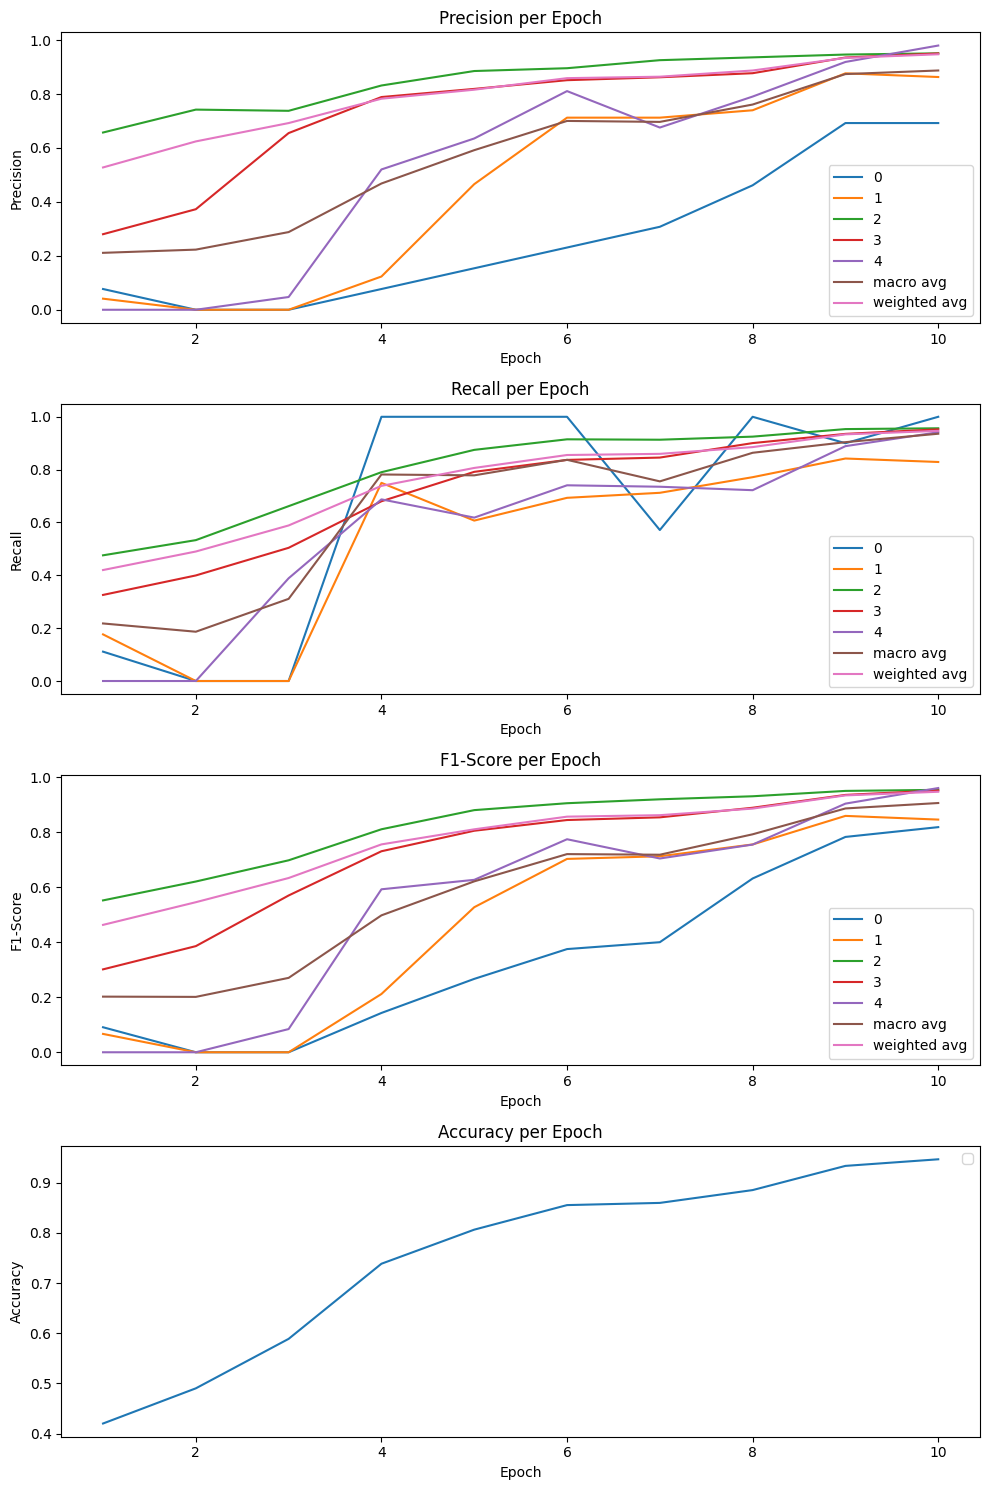

<Figure size 640x480 with 0 Axes>

In [25]:
plot_reports("Train",alltrainreps)

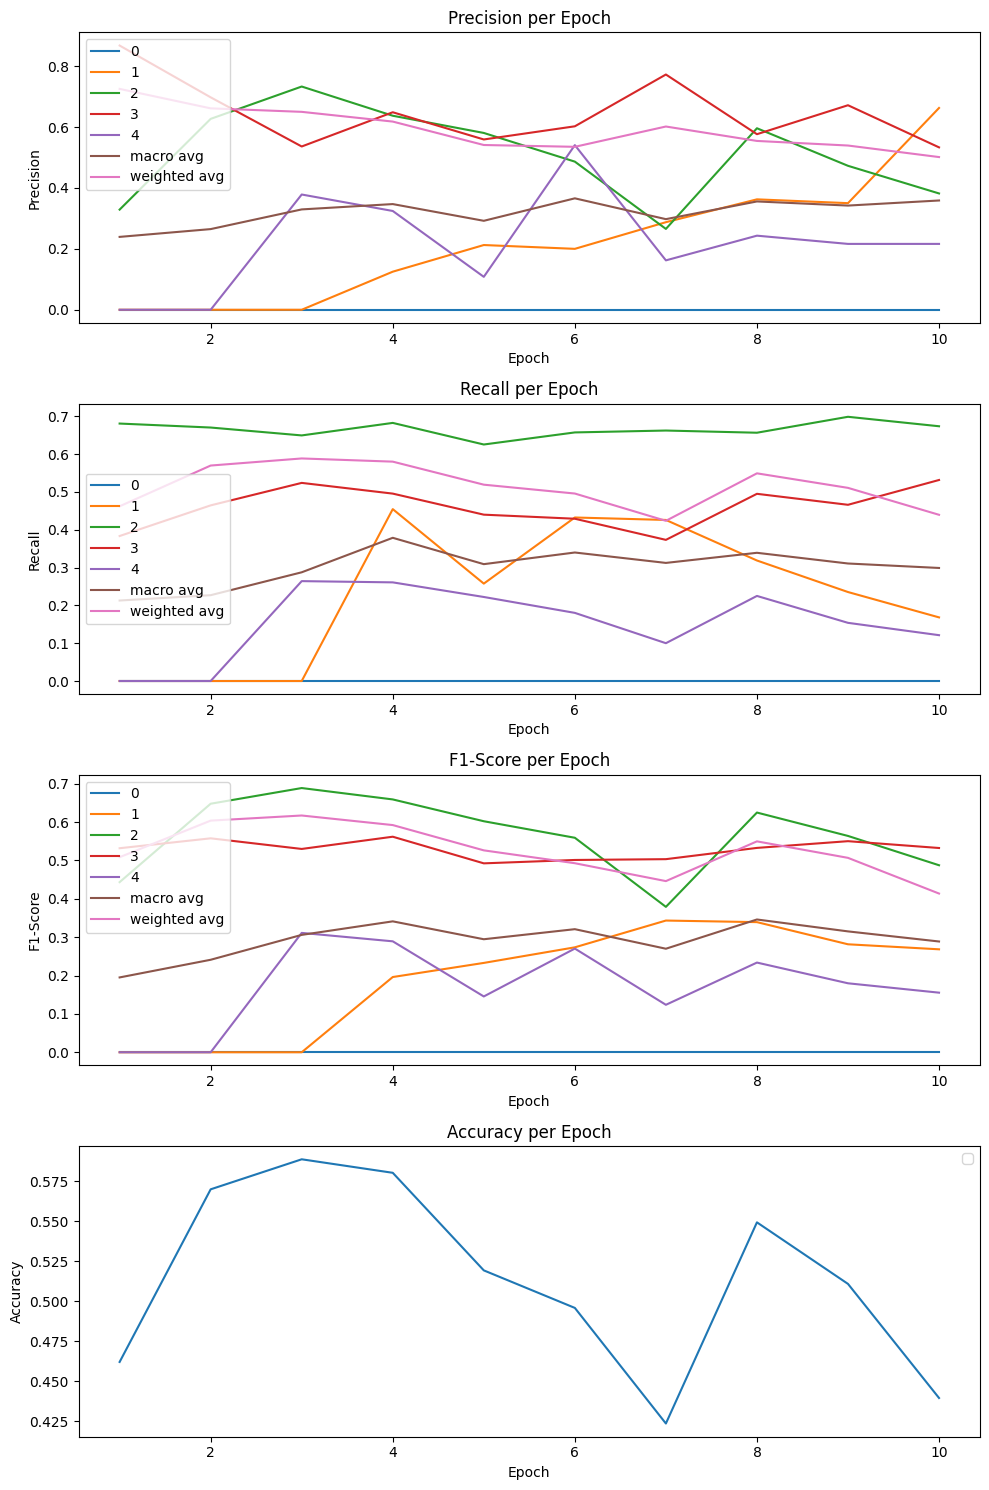

<Figure size 640x480 with 0 Axes>

In [26]:
plot_reports("Validation",allvalreps)